Here we reproduce the result of Codes and perform other tasks.

The original example doesn't have dark matter component, so we left the tests with this component for other notebook.


Originally, the example have the following parameters:
             
- ml        = 1.2             $[M_\odot/L_\odot]$
- beta      = 0.3             $[ad]$
- inc       = 60              $[deg]$
- log_mbh   = 8               $[log(M/M_\odot)]$
- mag_shear = 0.02            $[ad?]$
- phi_shear = 124             $[deg]$
- gamma     = 3               $[ad]$

In [1]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"


#General packages
import numpy as np
from My_Jampy import JAM
import emcee
import matplotlib.pyplot as plt

#MPI
from schwimmbad import MPIPool

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.constants import G, M_sun, c
import astropy.units as u

#Autolens Model packages
import autolens as al
import autolens.plot as aplt

#Combined Model package
import CombinedModel

In [2]:
#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

In [3]:
#Dataset path
dataset_path = "/home/carlos/Documents/GitHub/Master-Degree/Autolens_tests/autolens_workspace/Test_2/Data"

In [4]:
#Reading data of MGE and velocity dispersion maps
surf_lum, sigma_lum, qobs_lum = np.loadtxt("mge.txt", unpack=True)      #MGE data
xbin, ybin, goodbins, vrms  = np.loadtxt("vrms.txt", unpack=True)       #velocity dispersion map data


In [5]:
## Global informations and parameters
distance = 16.5 * u.Mpc                         #Lens galaxy distance [Mpc]

z = z_at_value(cosmo.angular_diameter_distance, distance, zmax=1.0) #Convert distance to redshifth 
z_lens = z                                    #Lens redshifth
z_source = 2.1                                #Source redshift

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_lens)                   #Lens              
D_s = cosmo.angular_diameter_distance(z_source)                 #Source
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)   #Lens to source

## Original Parameters

    First we test against original parameters. Which means: No dark matter, scalar ml, and scalar beta.

In [6]:
## Models inicialization

"""
To inicialize the model, we set some random values for the parameters. But it's only necessary for initialize the model. During the non-linear search, this values will be updated constantly until the best fit.
"""  
    #This quantities are our unknown parameters
inc = 75                                             #Inclination [deg]
mbh = np.random.random()                             #Mass of black hole [M_sun]
beta = np.full_like(surf_lum, np.random.random())    #Anisotropy
ml = np.random.random()                     #Mass to light ratio [M_sun/L_sun]
mag_shear = np.random.random()              #Shear magnitude
phi_shear = np.random.random()              #Shear angle
gamma = np.random.random()                  #Gamma

In [7]:
# Jampy Model

#Defining some instrumental quantities and galaxy characteristics
pixsize=0.8                                            #pixscale of IFU [arcsec/px]
normpsf=np.array([0.7, 0.3])                           #normalized intensity of IFU PSF
sigmapsf=np.array([0.6, 1.2])                          #sigma of each gaussian IFU PSF [arcsec]

#Create model
Jampy_model = JAM(ybin=ybin, xbin=xbin, inc=inc, distance=D_l.value, mbh=mbh,
                    rms=vrms, beta=beta, normpsf=normpsf, sigmapsf=sigmapsf, pixsize=pixsize)

#Add Luminosity component
Jampy_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                        qobs_lum=qobs_lum, ml=ml)

In [8]:
# Pyautolens Model

#Reading fits file with the arcs data
pixel_scales = 0.1
imaging = al.Imaging.from_fits(
            image_path=f"{dataset_path}/image.fits",
            noise_map_path=f"{dataset_path}/noise.fits",
            psf_path=f"{dataset_path}/psf.fits",
            pixel_scales=pixel_scales,
        )

#Load mask
mask_custom = al.Mask.from_fits(
        file_path=f"{dataset_path}/mask.fits", hdu=0, pixel_scales=pixel_scales)
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_custom, inversion_uses_border=True)

#Initializing
mass_profile = al.mp.MGE()

#Components
mass_profile.MGE_comps(z_l=z_lens, z_s=z_source, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh)

#Grid
mass_profile.MGE_Grid_parameters(masked_imaging.grid)

In [9]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='scalar')     #Setting scalar ML
model.beta(beta_kind='scalar')            #Seting scalar anisotropy

In [ ]:
model.has_DM(a=False)     #AVOID DARK MATTER COMPONENT

Now we give the initial parameters and let the magic happens. Note that __quiet__ keyword is set __False__, because we want to see the plots. But, when emcee run, you will probably want to disable it.

   ### !!!!!!!   PAY TOO MUCH ATTENTION TO THE ORDER OF PARAMETERS.   !!!!!!!!

jam_axi_rms elapsed time sec: 0.85
inc=60.0 beta_z=0.30 M/L=1 BH=1.00e+08 chi2/DOF=0.774
Total mass MGE: 6.728e+10


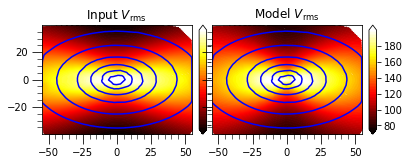

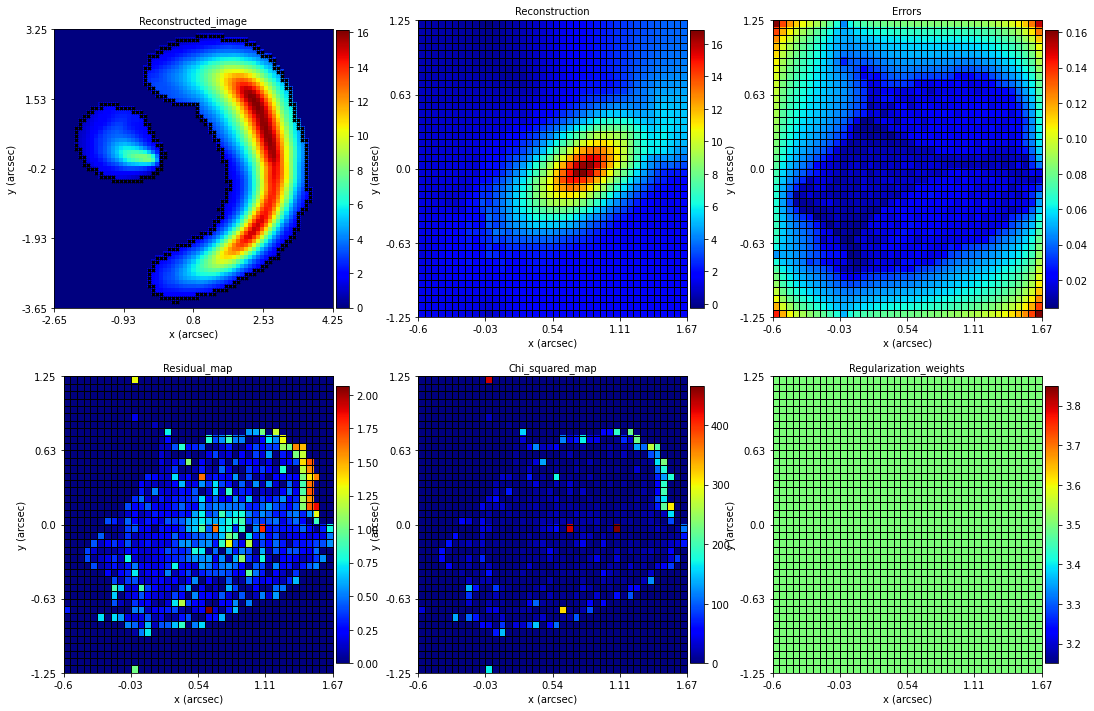

-8659.25244178217

In [23]:
#In order: ML, beta, inc, log_mbh, mag_shear, phi_shear, gamma 
p0 = np.array([1.2, 0.3, 60, 8, 0.02, 142, 3.0])      #Parameters
model(p0)                                             #Call plots

## Gradient Mass-to-light
    Now we test the gradient mass to light ratio. It should have same size of surf_lum.
    Here, we set all componentes equal, because we want to compare with the above result.
    But, in principle, each gaussian component must have it is on ML.

In [35]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='gradient')     #Setting scalar ML
model.beta(beta_kind='scalar')              #Seting scalar anisotropy

jam_axi_rms elapsed time sec: 0.85
inc=60.0 beta_z=0.30 M/L=1 BH=1.00e+08 chi2/DOF=0.774
Total mass MGE: 6.728e+10


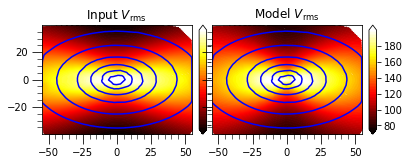

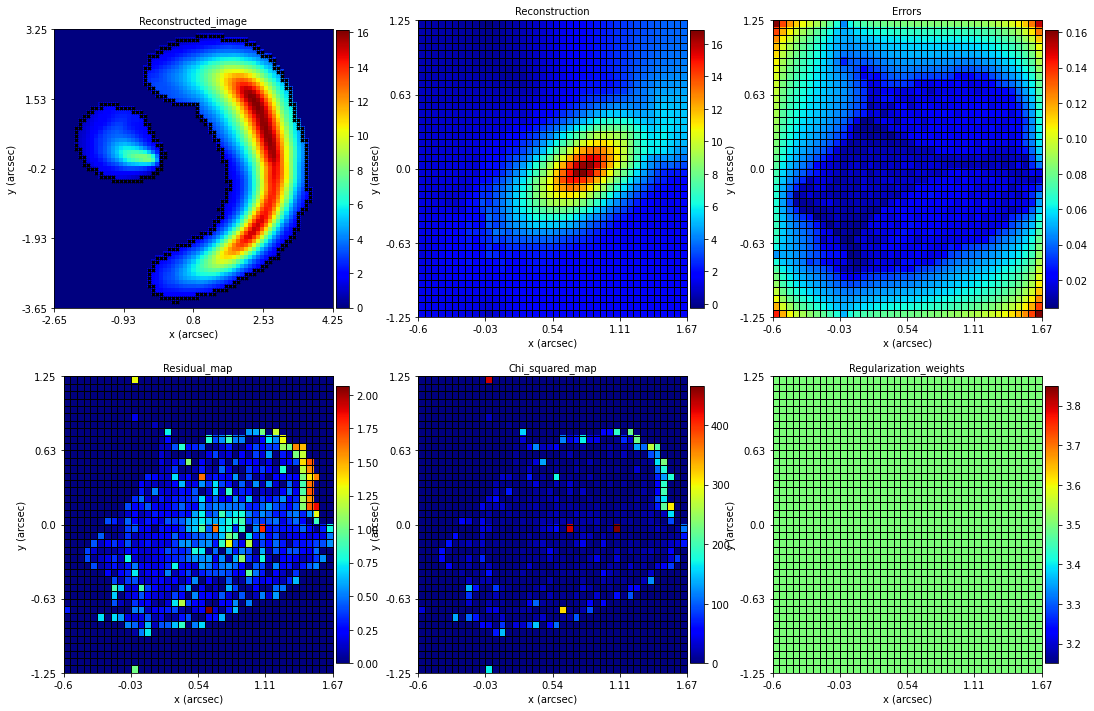

-8659.25244178217

In [36]:
#In order: ML, beta, inc, log_mbh, mag_shear, phi_shear, gamma
ML = np.full_like(surf_lum, 1.2)                    #ML vector
others = np.array([0.3, 60, 8, 0.02, 142, 3.0])     #Other parameters
p0 = np.append(ML, others)                          #Append all together

model(p0)                                           #Call plots

Once we test the ML gradient, and it works, let see if we give a ML gradient that not follow the constraint required.

In [29]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='gradient')     #Setting scalar ML
model.beta(beta_kind='scalar')              #Seting scalar anisotropy

In [31]:
#In order: ML, beta, inc, log_mbh, mag_shear, phi_shear, gamma
ML = np.array([1.2, 3.4, 0.4, 4.0, 2.7, 14, 9, 8, 9, 10 ]) #ML vector
others = np.array([0.3, 60, 8, 0.02, 142, 3.0])            #Other parameters
p0 = np.append(ML, others)                                 #Append all together
#Note that ML have same size as surf_lum, but it is not a gradient.
#So, We hope that the model is not accepted, and returns -np.inf.

 
model(p0) 

-inf

Bam! Exactly what we expect!

## Gaussian Mass-to-light
    Now we test the gaussian mass to light ratio. In this case, we have three parameters:
    central mass to light (ml0), inverse gaussian sigma (delta) and lower value of ml (lower).
    
    First, we give lower equal to one, because it makes the ml constant, and allow us to compare with the above models.

In [12]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='gaussian')   #Setting scalar ML
model.beta(beta_kind='scalar')            #Seting scalar anisotropy

jam_axi_rms elapsed time sec: 0.81
inc=60.0 beta_z=0.30 M/L=1 BH=1.00e+08 chi2/DOF=0.774
Total mass MGE: 6.728e+10


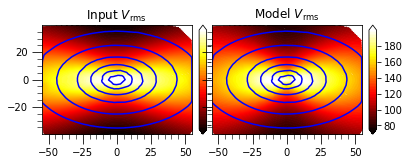

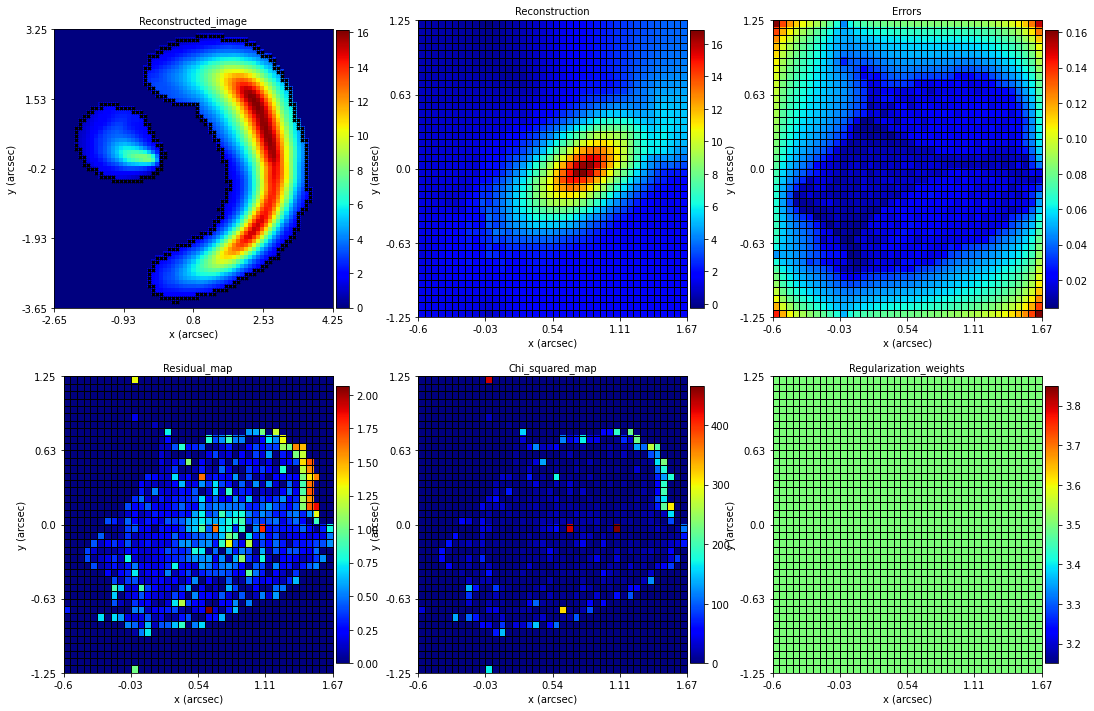

-8659.25244178217

In [13]:
#In order: ML0, delta, lower beta, inc, log_mbh, mag_shear, phi_shear, gamma
p0  = np.array([1.2, 0.5, 1, 0.3, 60, 8, 0.02, 142, 3.0])
model(p0)   

## Beta vector
    Now we test beta as a vector, i.e, one beta per gaussian luminosity.
    To compare with previous models, we set all beta equal. But, in principle, we can set one beta per gaussian component.
    
    

In [10]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='scalar')     #Setting scalar ML
model.beta(beta_kind='vector')            #Seting scalar anisotropy

jam_axi_rms elapsed time sec: 0.87
inc=60.0 beta_z=0.30 M/L=1 BH=1.00e+08 chi2/DOF=0.774
Total mass MGE: 6.728e+10


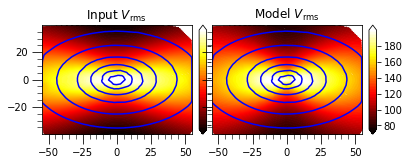

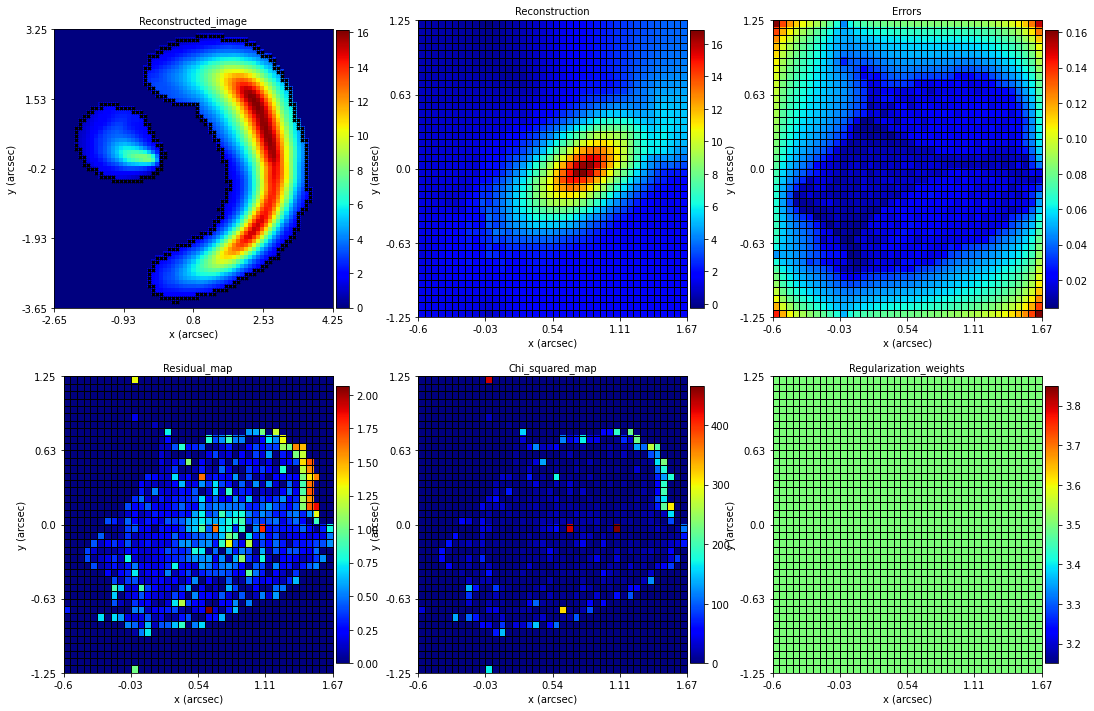

-8659.25244178217

In [11]:
#In order: ML, beta, inc, log_mbh, mag_shear, phi_shear, gamma 
ml   = np.array([1.2])                 #ML
beta = np.full_like(surf_lum, 0.3)     #one beta per luminosity component
p0   = np.append(ml, beta)

others = np.array([60, 8, 0.02, 142, 3.0])            #Other parameters
p0     = np.append(p0, others)                        #All parameters

model(p0)                                             #Call plots

Just for completeness, we set a arbitrary beta vector. Let's take a look.

In [14]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='scalar')     #Setting scalar ML
model.beta(beta_kind='vector')            #Seting scalar anisotropy

jam_axi_rms elapsed time sec: 0.76
inc=60.0 beta_z=-1.70 M/L=1 BH=1.00e+08 chi2/DOF=4
Total mass MGE: 6.728e+10


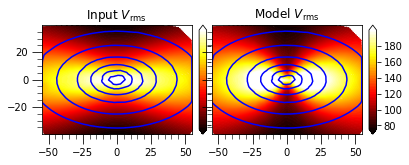

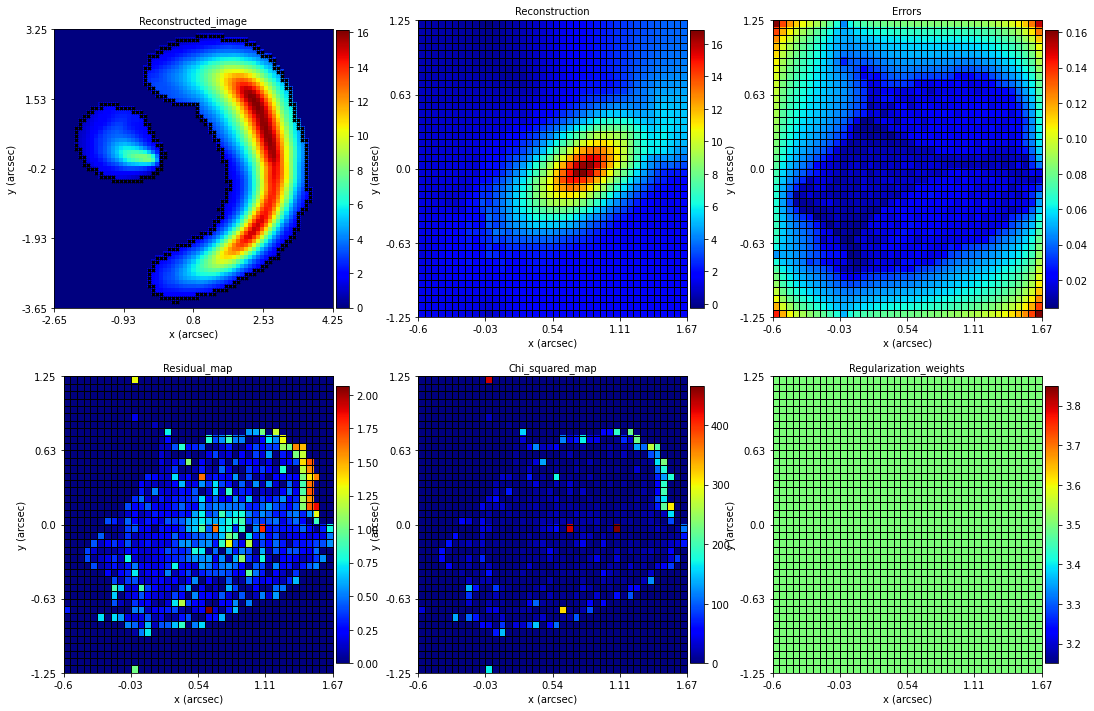

-10273.035597216905

In [19]:
#In order: ML, beta, inc, log_mbh, mag_shear, phi_shear, gamma 
ml   = np.array([1.2])                 #ML
beta = np.array([-1.7, 0.4, 3.4, 0.1, -2.7, -1, 0.3, 0.2, -1.2, -4.0 ])     #one beta per luminosity component
p0   = np.append(ml, beta)

others = np.array([60, 8, 0.02, 142, 3.0])            #Other parameters
p0     = np.append(p0, others)                        #All parameters

model(p0)                                             #Call plots

## Beta vector and M/L gradient
    Finally, we mix things. First we set a beta vector and a ml gradient. To compare, frist, we set them as a constant vectors. But we have a toy example after.

In [34]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='gradient')     #Setting scalar ML
model.beta(beta_kind='vector')              #Seting scalar anisotropy

jam_axi_rms elapsed time sec: 0.75
inc=60.0 beta_z=0.30 M/L=1 BH=1.00e+08 chi2/DOF=0.774
Total mass MGE: 6.728e+10


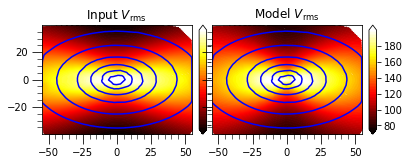

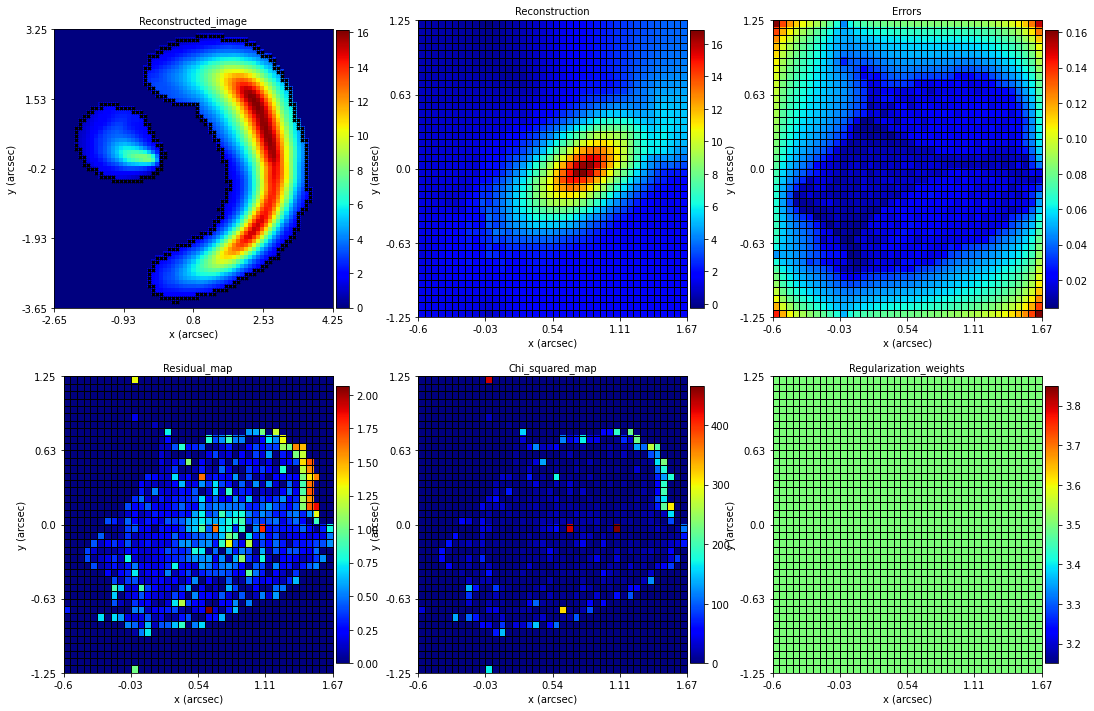

-8659.25244178217

In [35]:
#In order: ML, beta, inc, log_mbh, mag_shear, phi_shear, gamma 
ml   = np.full_like(surf_lum, 1.2)     #ML
beta = np.full_like(surf_lum, 0.3)     #one beta per luminosity component
p0   = np.append(ml, beta)

others = np.array([60, 8, 0.02, 142, 3.0])            #Other parameters
p0     = np.append(p0, others)                        #All parameters

model(p0)                                             #Call plots

Now, we test a toy model

In [27]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='gradient')   #Setting scalar ML
model.beta(beta_kind='vector')            #Seting scalar anisotropy

jam_axi_rms elapsed time sec: 0.91
inc=60.0 beta_z=-1.70 M/L=1 BH=1.00e+08 chi2/DOF=187
Total mass MGE: 1.399e+11


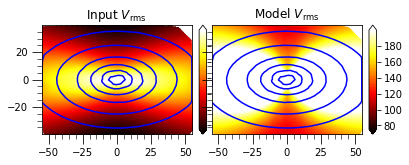

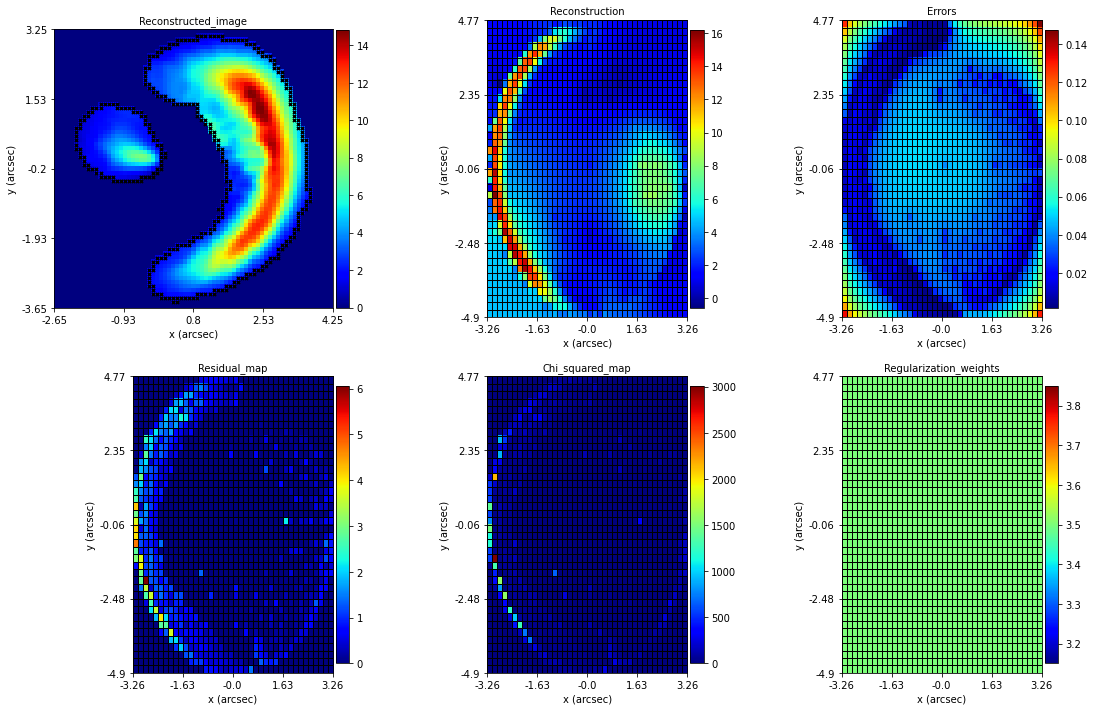

-122429.2348160521

In [29]:
#In order: ML, beta, inc, log_mbh, mag_shear, phi_shear, gamma 
ml   = np.array([5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.6])     #ML
beta = np.array([-1.7, 0.4, 3.4, 0.1, -2.7, -1, 0.3, 0.2, -1.2, -4.0 ])     #one beta per luminosity component
p0   = np.append(ml, beta)

others = np.array([60, 8, 0.02, 142, 3.0])            #Other parameters
p0     = np.append(p0, others)                        #All parameters

model(p0)                                             #Call plots

Of course the result is dramatic. But this illustrate how set this combination.

## Beta vector and gaussian M/L 
    As a last example, we set a gaussian ML and a vector beta. With arbitrary values, just for fun.

In [30]:
#Initializing combined model

#Just remembering, by default the model does not include dark matter.
model = CombinedModel.Models(Jampy_model=Jampy_model, mass_profile=mass_profile,
                                 masked_imaging=masked_imaging, quiet=False)
model.mass_to_light(ml_kind='gaussian')     #Setting scalar ML
model.beta(beta_kind='vector')              #Seting scalar anisotropy

jam_axi_rms elapsed time sec: 0.79
inc=60.0 beta_z=-1.70 M/L=1 BH=1.00e+08 chi2/DOF=11.8
Total mass MGE: 4.593e+10


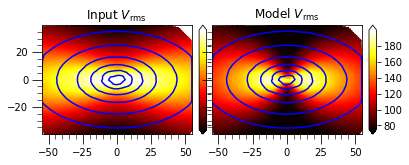

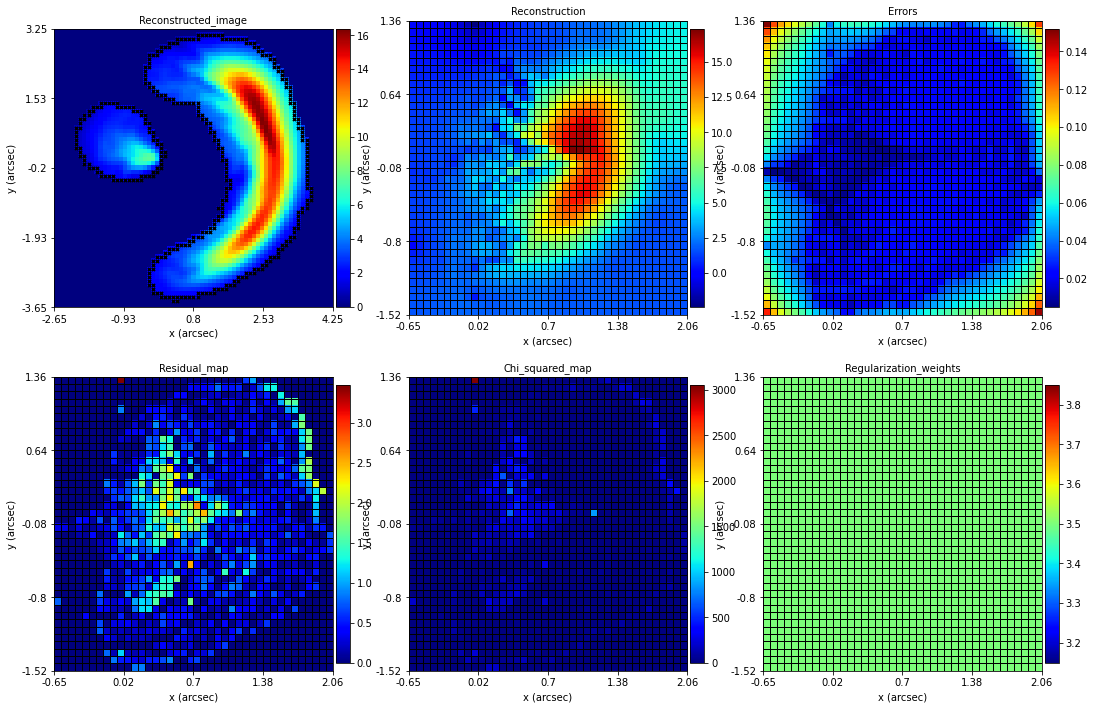

-32482.769541848258

In [31]:
#In order: ML-gaussian, beta, inc, log_mbh, mag_shear, phi_shear, gamma 
ml   = np.array([2.0, 1, 0.4])                   # ML0, delta, lower
beta = np.array([-1.7, 0.4, 3.4, 0.1, -2.7, -1, 0.3, 0.2, -1.2, -4.0 ])     #one beta per luminosity component
p0   = np.append(ml, beta)

others = np.array([60, 8, 0.02, 142, 3.0])            #Other parameters
p0     = np.append(p0, others)                        #All parameters

model(p0)                                             #Call plots

__Awesome!!!__

__Now, we have to check how this models behave with inclusion of dark matter component!__